In [24]:
import json

import numpy
import pandas
import seaborn

import scipy.stats

In [2]:
pandas.set_option('display.float_format', lambda x: f'{x:,.6f}')

In [94]:
COUNTRY_FILTER = [
    "France",
    "Egypt",
    "Saudi Arabia",
    "Russia",
    "Mexico",
    "Japan",
]

MODEL_FILTER = ["human", "llama3.1:8b", "mistral:7b"]

In [4]:
dataset_long = pandas.read_parquet("reports/dataset.long.parquet")
dataset_long

dimension  response
segment         id model       persona                      
descriptiveness 1  llama3.1:8b Argentina      care  5.000000
                               Argentina      care  5.000000
                               Argentina      care  5.000000
                               Argentina      care  5.000000
                               Argentina      care  5.000000
...                                            ...       ...
                36 qwen2.5:72b UAE          purity  3.000000
                               UAE          purity  4.000000
                               UAE          purity  4.000000
                               UAE          purity  3.000000
                               UAE          purity  4.000000

[166255 rows x 2 columns]

In [5]:
dataset_long_human = (
    pandas.DataFrame(json.load(open("../../../data/moral_foundations_2/surveys.json"))["atari_et_al"]["country"])
    .T
    .melt(ignore_index=False)
    .reset_index()
    .rename(columns={
        "index": "persona",
        "variable": "dimension",
        "value": "response",
    })
    .assign(model="human")
)
dataset_long_human

,persona,dimension,response,model
0,Argentina,care,3.840000,human
1,Belgium,care,3.910000,human
2,Chile,care,3.770000,human
3,Colombia,care,3.830000,human
4,Egypt,care,4.380000,human
...,...,...,...,...
109,Russia,purity,3.250000,human
110,Saudi Arabia,purity,3.980000,human
111,South Africa,purity,3.400000,human
112,Switzerland,purity,2.950000,human


In [6]:
df_prep = (
    dataset_long
    .groupby(["model", "persona", "dimension"], observed=True)
    ["response"]
    .agg("mean")
    .reset_index()
    .pipe(lambda _df: pandas.concat([dataset_long_human, _df], ignore_index=True))
    .pipe(
        lambda _df: _df.assign(dimension_projection=pandas.Series(pandas.factorize(_df["dimension"])[0]) * 60)
    )
)
df_prep

,persona,dimension,response,model,dimension_projection
0,Argentina,care,3.840000,human,0
1,Belgium,care,3.910000,human,0
2,Chile,care,3.770000,human,0
3,Colombia,care,3.830000,human,0
4,Egypt,care,4.380000,human,0
...,...,...,...,...,...
793,UAE,care,4.713333,qwen2.5:72b,0
794,UAE,equality,3.153333,qwen2.5:72b,60
795,UAE,loyalty,4.496667,qwen2.5:72b,180
796,UAE,proportionality,4.226667,qwen2.5:72b,120


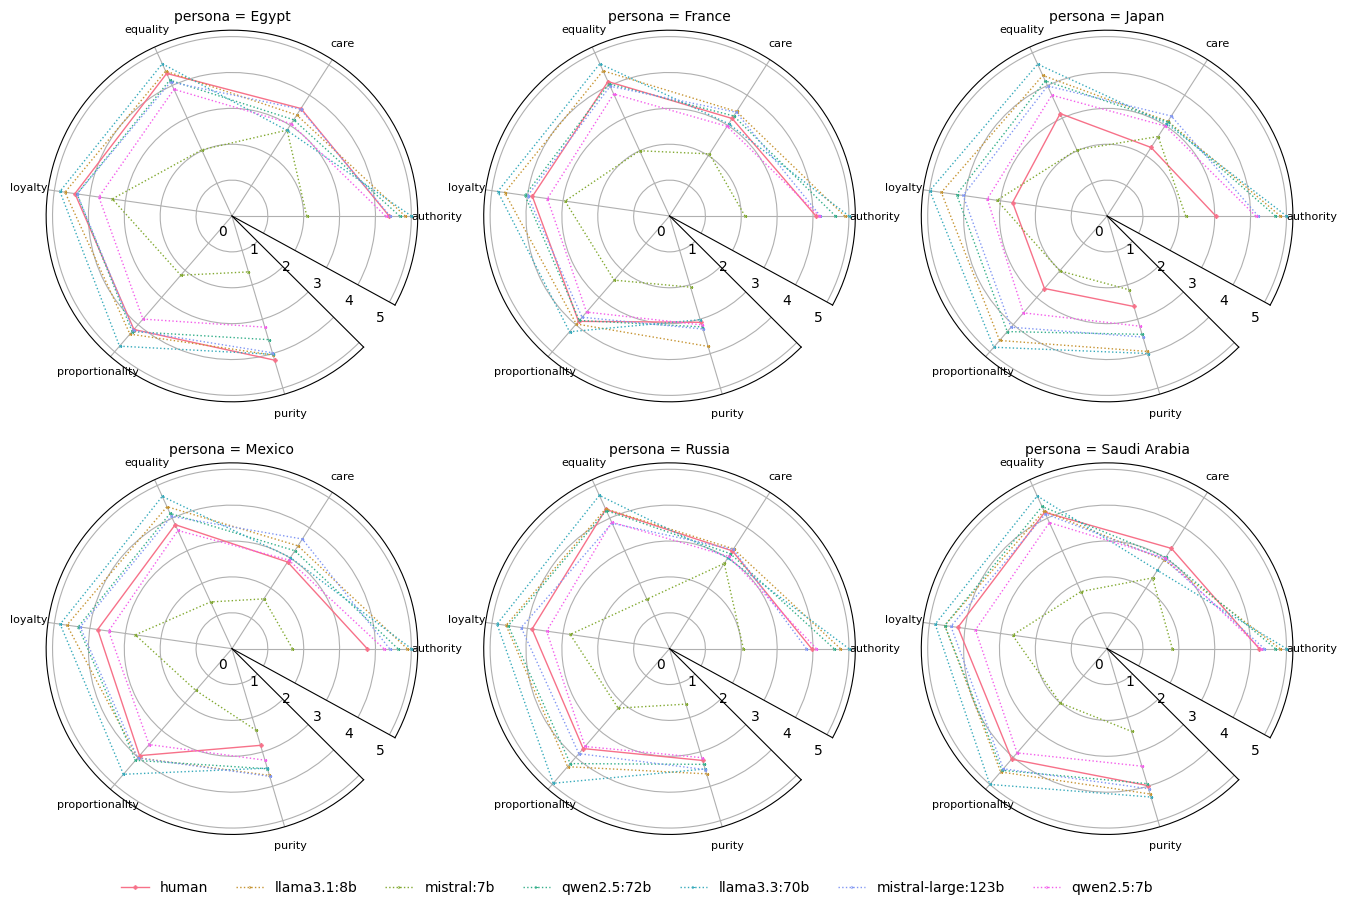

In [ ]:
grid = seaborn.FacetGrid(
    (
        df_prep
        [df_prep["persona"].isin(COUNTRY_FILTER)]
    ), 
    col="persona",
    col_wrap=3,
    height=4.5,
    sharex=False, 
    sharey=True, 
    despine=False,
    subplot_kws=dict(
        projection='polar',
    ),
)

grid.map_dataframe(
    seaborn.pointplot, 
    x="dimension_projection", 
    y="response",
    hue="model",
    lw=1,
    markers=["P"] + ["4"] * (len(df_prep["model"].unique()) - 1),
    linestyles=["-"] + [":"] * (len(df_prep["model"].unique()) - 1),
    palette=seaborn.color_palette("husl", len(df_prep["model"].unique()))
)

grid.add_legend(
    title="",
    bbox_to_anchor=(0.5, 0.0),
    ncol=int(len(df_prep["persona"].unique())),
)

for ax in grid.axes.flat:
    ax.grid(True)

    # ax.set_title(ax.get_title(), pad=20)
    
    ax.set_xlabel(xlabel="")
    ax.set_ylabel(ylabel="")

    ax.set_xticks(list(range(6)))
    ax.set_xticklabels(list(dataset_long["dimension"].cat.categories))
    ax.tick_params(axis='x', labelsize=8)

grid.savefig("reports/polar.dimensions.by_persona.pdf")

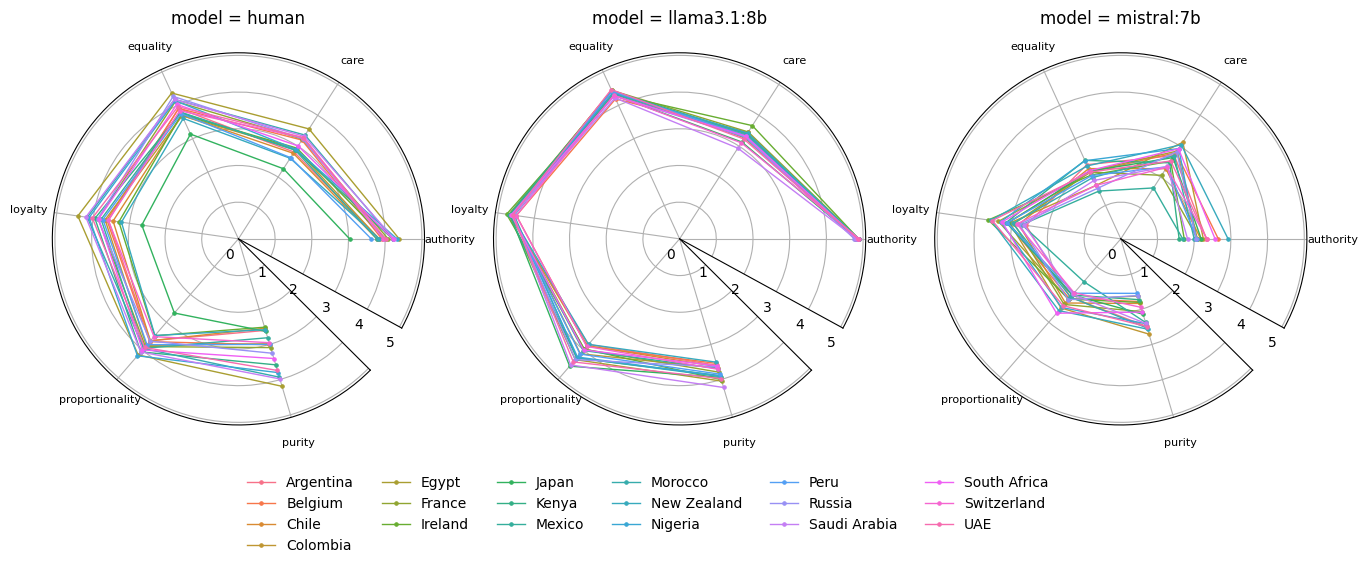

In [95]:
grid = seaborn.FacetGrid(
    (
        df_prep
        [df_prep["model"].isin(MODEL_FILTER)]
    ), 
    col="model",
    col_wrap=3,
    hue="persona",
    height=4.5,
    sharex=True, 
    sharey=True, 
    despine=False,
    subplot_kws=dict(projection='polar'),
)

grid.map_dataframe(
    seaborn.pointplot, 
    x="dimension_projection", 
    y="response",
    lw=1
)

grid.add_legend(
    title="",
    bbox_to_anchor=(0.5, -0.1),
    ncol=int(len(df_prep["persona"].unique()) / 3),
)

for ax in grid.axes.flat:
    ax.grid(True)

    ax.set_title(ax.get_title(), pad=20)
    
    ax.set_xlabel(xlabel="")
    ax.set_ylabel(ylabel="")

    ax.set_xticks(list(range(6)))
    ax.set_xticklabels(list(dataset_long["dimension"].cat.categories))
    ax.tick_params(axis='x', labelsize=8, pad=8)

grid.savefig("reports/polar.dimensions.by_model.pdf")


In [7]:
(
    df_prep
    .groupby(["model", "persona", "dimension"])
    ["response"]
    .agg("mean")
    .to_frame()
    .reset_index()
    .pipe(lambda _df: _df[_df["persona"].isin(COUNTRY_FILTER)])
    .pivot(index=["persona", "dimension"], columns=["model"], values=["response"])
    .droplevel(level=0, axis=1)
    .pipe(
        lambda _df: _df.subtract(_df["human"], axis=0)
    )
    .drop(columns=["human"])
    # styling
    #.style
    #.map_index(lambda v: "rotatebox:{65}--rwrap--latex;", level=0, axis=1) 
    #.background_gradient(axis=1, vmin=-0.75, vmax=0.75, cmap=seaborn.color_palette("vlag", as_cmap=True)) 
    #.highlight_between(left=-0.1, right=0.1, props='font-weight:bold') 
    #.format(precision=3) 
    #.to_latex(convert_css=True, clines="all;data", hrules=True)
)

model                         llama3.1:8b  llama3.3:70b  mistral-large:123b  \
persona      dimension                                                        
Egypt        authority           0.169153      0.613333            0.031009   
             care                0.446667      0.620000            0.024545   
             equality           -0.215405     -0.723333           -0.021905   
             loyalty             0.278997      0.423333           -0.060553   
             proportionality     0.071077      0.296667           -0.261892   
             purity             -0.147597     -0.170000           -0.213923   
France       authority           0.096431      0.383333           -0.151028   
             care                0.801757      0.920000            0.124255   
             equality            0.231538     -0.176667            0.207788   
             loyalty             0.780678      0.976667            0.135633   
             proportionality     0.330847      0.546667           -0.143256   
             purity              0.699474     -0.076667            0.195047   
Japan        authority           1.913893      2.163333            1.425960   
             care                1.798859      1.970000            1.178696   
             equality            0.867124      0.793333            1.041558   
             loyalty             2.006667      2.333333            1.393571   
             proportionality     1.168725      1.513333            0.846301   
             purity              1.305943      1.366667            0.889231   
Mexico       authority           0.080134      0.686667            0.083148   
             care                1.110952      1.230000            0.621489   
             equality            0.536040      0.146667            0.760901   
             loyalty             0.866465      1.056667            0.490742   
             proportionality     0.551351      0.866667            0.256034   
             purity              0.874588      0.663333            0.902264   
Russia       authority           0.666939      1.276667            0.186337   
             care                0.803514      1.040000           -0.145841   
             equality            0.064795     -0.236667            0.047671   
             loyalty             0.732694      0.986667            0.305676   
             proportionality     0.013784      0.426667           -0.425251   
             purity              0.388686      0.246667            0.265625   
Saudi Arabia authority           0.470268      0.930000            0.354779   
             care                0.579398      0.760000            0.142979   
             equality           -0.382069     -0.726667           -0.358095   
             loyalty             0.370470      0.640000            0.197196   
             proportionality     0.044138      0.500000           -0.048996   
             purity              0.243529      0.333333            0.091795   

model                         mistral:7b  qwen2.5:72b  qwen2.5:7b  
persona      dimension                                             
Egypt        authority         -1.998182     0.076667   -0.383333  
             care              -2.295254     0.293333   -0.100000  
             equality          -0.716250    -0.373333   -0.502761  
             loyalty           -1.051579    -0.056667   -0.673333  
             proportionality   -2.342973    -0.206667   -0.487057  
             purity            -2.565000    -0.596667   -0.958707  
France       authority         -1.517931    -0.033333   -0.341279  
             care              -1.977959     0.543333    0.094497  
             equality          -1.172857     0.083333   -0.260201  
             loyalty           -0.918824     0.210000   -0.420811  
             proportionality   -2.120000    -0.070000   -0.379259  
             purity            -1.021034     0.133333    0.074384  
Japan        authority         -0.649592     

In [47]:
dist = (
    df_prep
    .set_index(["model", "persona", "dimension"])
    [["response"]]
    .reset_index()
    .pivot(
        index=["dimension"],
        columns=["model", "persona"],
        values="response"
    )
    .corr(method=lambda x, y: numpy.linalg.norm(x - y), numeric_only=True)
    .xs('human', level='model', axis=1)
    .drop(index="human")
    .melt(ignore_index=False)
    .rename(columns={"persona": "human"})
    .reset_index()
    # styling
    # .style
    # .background_gradient(axis=None) # subset=[('model', "llama3.1:8b")]
    # .format(precision=3)  
    # .to_latex(convert_css=True, clines="all;data", hrules=True)
)

dist

/tmp/ipykernel_1575202/3291128363.py:13: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  .drop(index="human")


,model,persona,human,value
0,llama3.1:8b,Argentina,Argentina,1.947504
1,llama3.1:8b,Belgium,Argentina,1.764765
2,llama3.1:8b,Chile,Argentina,1.954266
3,llama3.1:8b,Colombia,Argentina,1.939330
4,llama3.1:8b,Egypt,Argentina,2.309821
...,...,...,...,...
2161,qwen2.5:72b,Russia,UAE,0.968980
2162,qwen2.5:72b,Saudi Arabia,UAE,1.161026
2163,qwen2.5:72b,South Africa,UAE,0.769993
2164,qwen2.5:72b,Switzerland,UAE,0.773240


In [98]:
print(
    dist[dist["persona"] == dist["human"]]
    .pivot(columns="model", index="human", values="value")
    .pipe(lambda _df: _df.assign(MEAN=_df.mean(axis=1)))
    .pipe(lambda _df: pandas.concat([
        _df, pandas.DataFrame([_df.mean()], index=["MEAN"])
    ]))
    .style
    .highlight_min(props="textbf:--rwrap", axis=1)
    .format(precision=3)  
    .map_index(
        lambda v: "rotatebox:{65}--rwrap--latex;", level=0, axis=1
    ) 
    .to_latex(convert_css=True, clines="all;data", hrules=True)
)

\begin{tabular}{lrrrrrrr}
\toprule
model & \rotatebox{65}{llama3.1:8b} & \rotatebox{65}{llama3.3:70b} & \rotatebox{65}{mistral-large:123b} & \rotatebox{65}{mistral:7b} & \rotatebox{65}{qwen2.5:72b} & \rotatebox{65}{qwen2.5:7b} & \rotatebox{65}{MEAN} \\
\midrule
Argentina & 1.948 & 2.182 & 1.503 & 2.924 & 1.365 & 0.765 & 1.781 \\
\cline{1-8}
Belgium & 1.399 & 1.750 & 0.451 & 3.092 & 0.875 & 0.358 & 1.321 \\
\cline{1-8}
Chile & 2.169 & 2.314 & 1.653 & 2.844 & 1.497 & 0.826 & 1.884 \\
\cline{1-8}
Colombia & 1.717 & 2.053 & 1.405 & 3.028 & 1.308 & 0.525 & 1.673 \\
\cline{1-8}
Egypt & 0.616 & 1.257 & 0.346 & 4.790 & 0.796 & 1.421 & 1.538 \\
\cline{1-8}
France & 1.383 & 1.511 & 0.398 & 3.738 & 0.608 & 0.721 & 1.393 \\
\cline{1-8}
Ireland & 2.506 & 2.528 & 1.326 & 3.322 & 1.393 & 0.658 & 1.956 \\
\cline{1-8}
Japan & 3.840 & 4.335 & 2.821 & 1.711 & 3.187 & 1.923 & 2.970 \\
\cline{1-8}
Kenya & 1.355 & 1.583 & 0.904 & 4.157 & 0.735 & 0.502 & 1.539 \\
\cline{1-8}
Mexico & 1.830 & 2.077 & 1.447 & 

<Axes: xlabel='value', ylabel='human'>

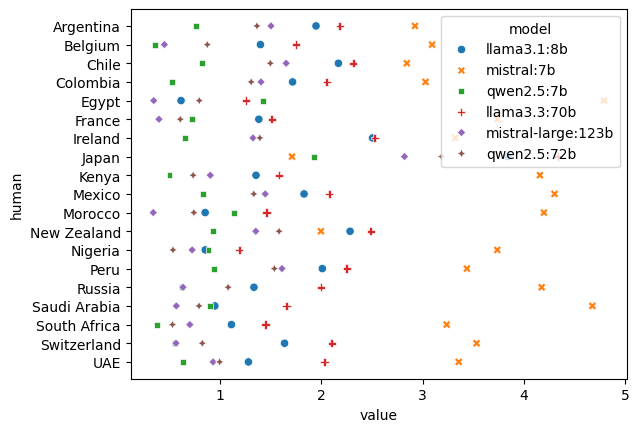

In [77]:
seaborn.scatterplot(dist[dist["persona"] == dist["human"]], y="human", x="value", hue="model", style="model")


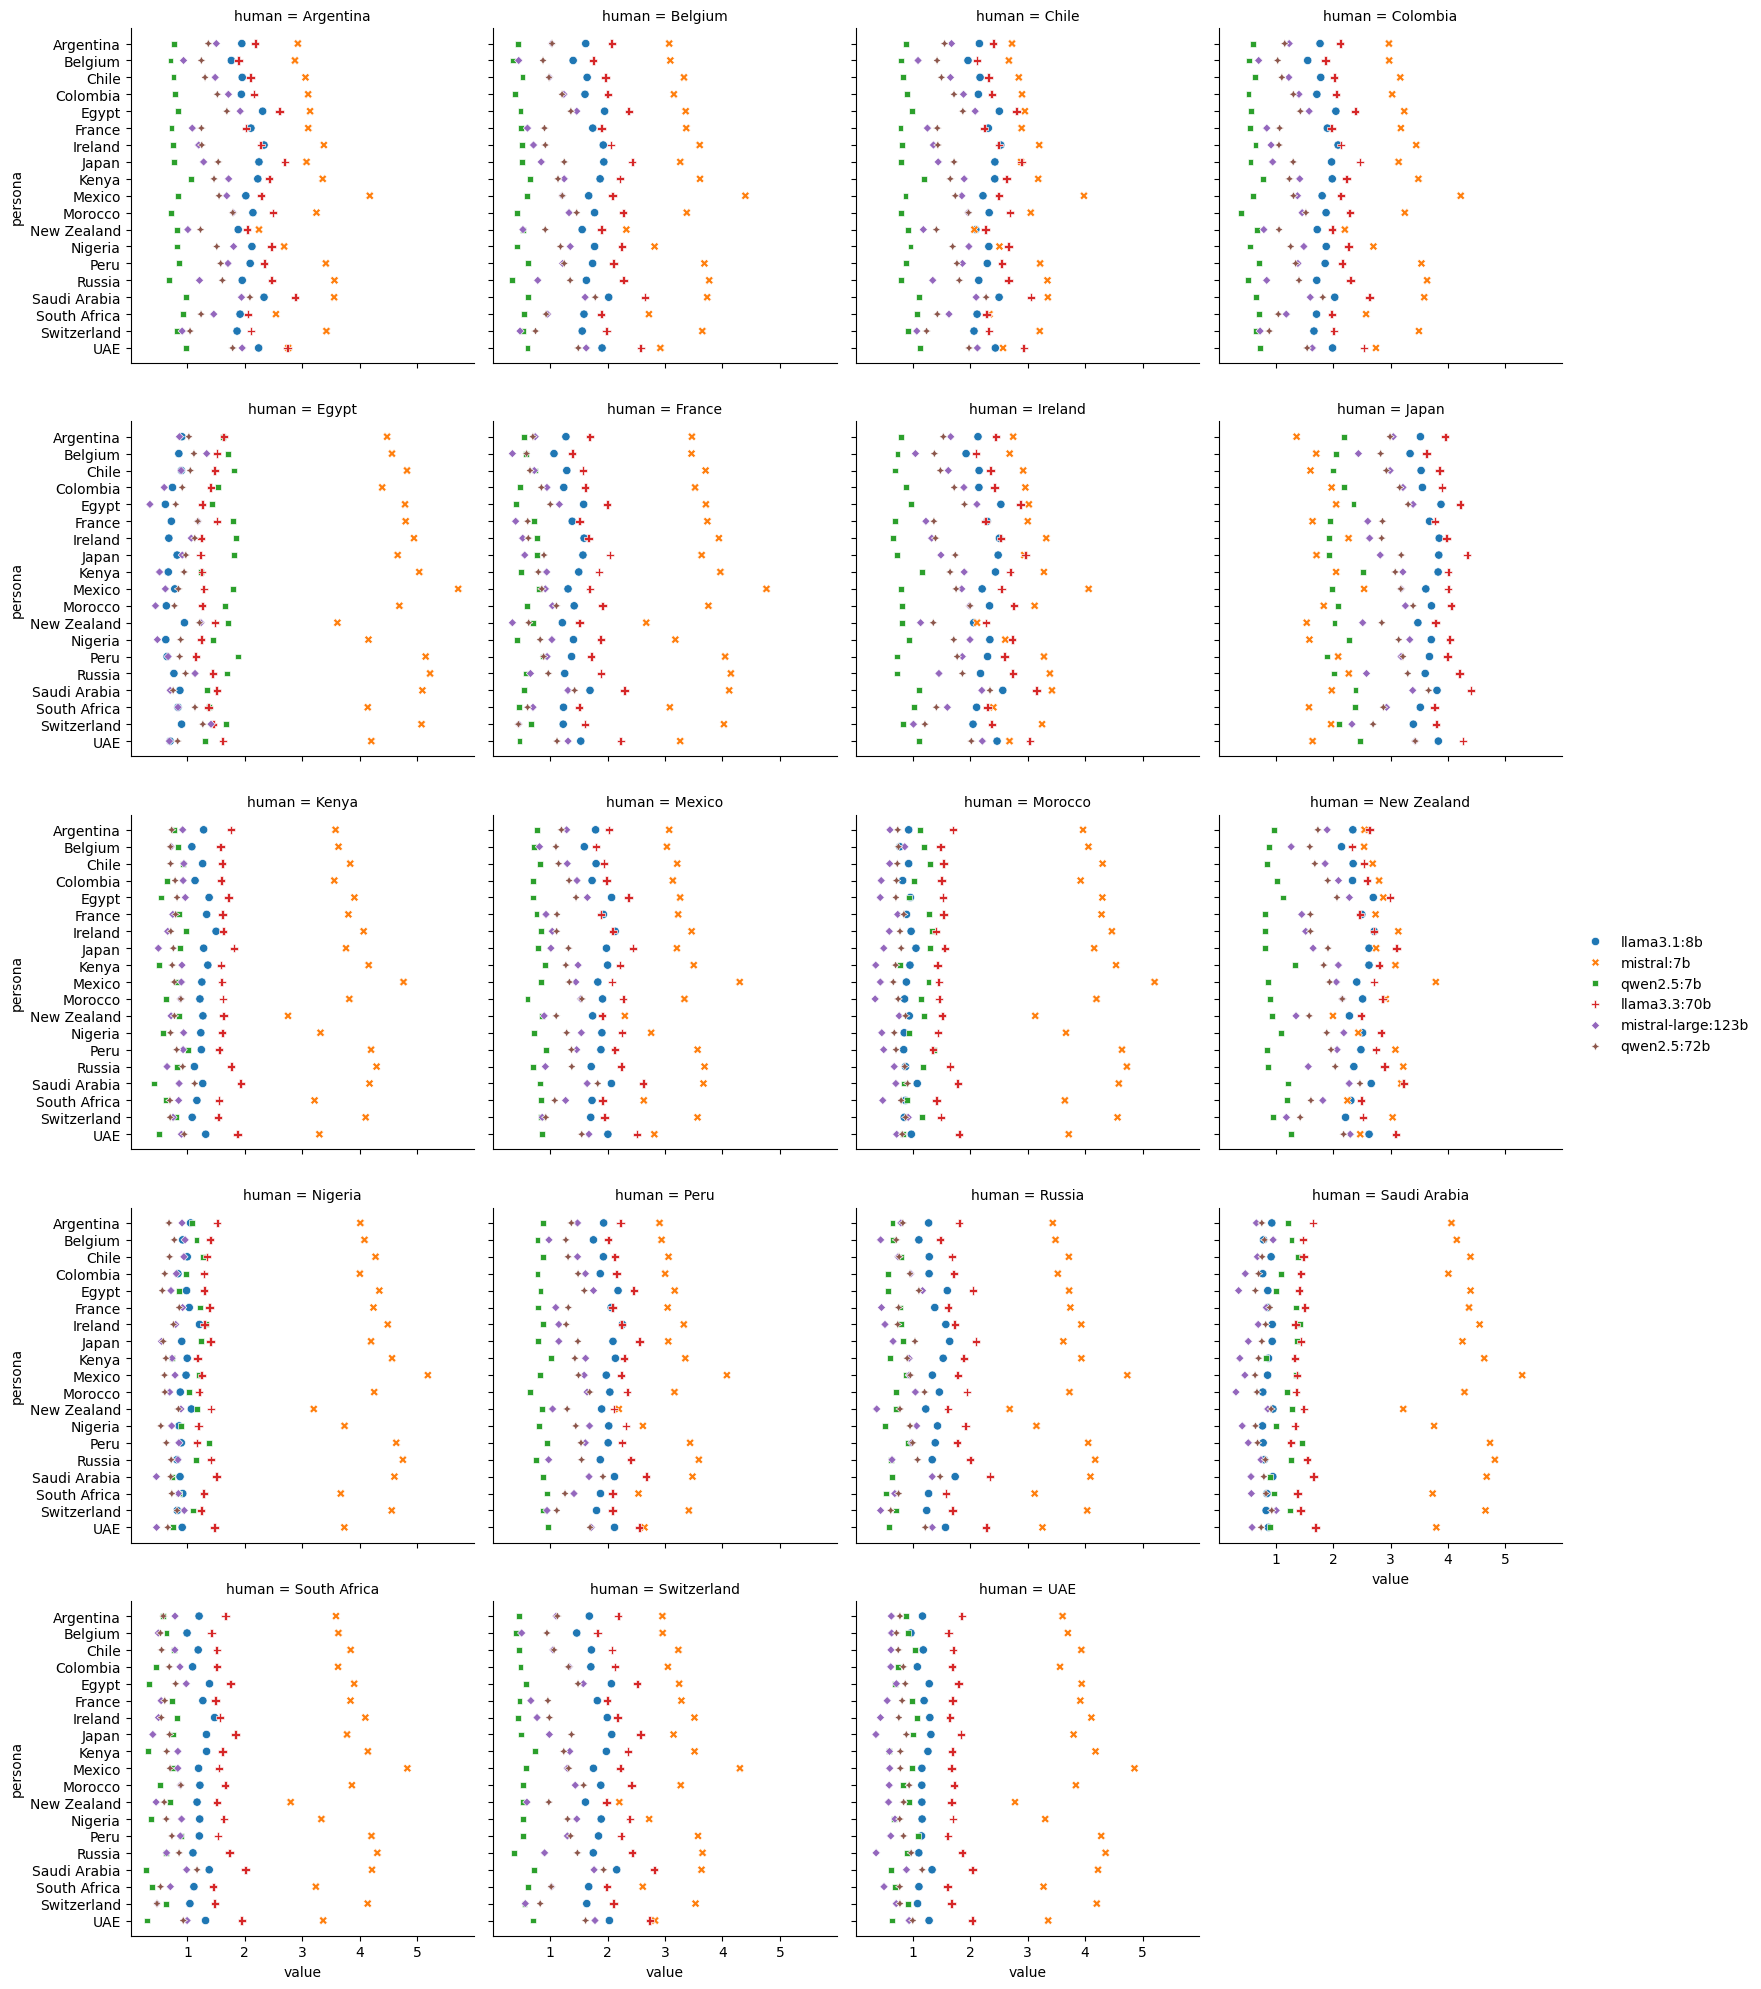

In [54]:
g = seaborn.FacetGrid(dist, col="human", height=4, sharey=True, col_wrap=4)
g.map_dataframe(seaborn.scatterplot, y="persona", x="value", hue="model", style="model")
g.add_legend()


In [306]:
(
    dataset_long
    .reset_index()
    .groupby(["id", "model", "persona"], observed=False)
    ["response"]
    .agg(list)
    .groupby(["id", "model"], observed=False)
    .agg(lambda row: scipy.stats.f_oneway(*row.values).pvalue)
    .unstack(level="model")
    .pipe(lambda _df: _df.assign(MEAN=_df.mean(axis=1)))
    .pipe(lambda _df: pandas.concat([
        _df, pandas.DataFrame([_df.mean()], index=["MEAN"])
    ]))
    .rename_axis(columns=None)
    .style
    .map(lambda v: 'opacity: 50%; color:red;' if (v > 0.05) else None)
    .highlight_null(props='opacity: 50%; color:red;')
    .map_index(
        lambda v: "rotatebox:{65}--rwrap--latex;", level=0, axis=1
    ) 
    .format(precision=5)
    # .to_latex(convert_css=True, clines="all;data", hrules=True)
)

/home/ubuntu/repositories/LLM-Questionnaires/.venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


,llama3.1:8b,mistral:7b,qwen2.5:72b,llama3.3:70b,mistral-large:123b,qwen2.5:7b,MEAN
1,0.01844,0.49854,0.00025,nan,0.00012,0.00151,0.10377
2,0.51522,nan,0.00000,nan,0.00000,0.10831,0.15588
3,0.04875,0.48597,0.04996,0.00000,0.05882,0.00133,0.10747
4,0.00003,0.11762,0.00000,0.00000,0.00000,0.00000,0.01961
5,0.00000,0.67451,0.00000,0.00000,0.00000,0.00000,0.11242
6,0.00029,0.11606,0.00000,0.00000,0.00000,0.00000,0.01939
7,0.47381,0.67889,0.00000,nan,0.18223,0.00000,0.26699
8,0.57577,0.11295,0.00501,0.00000,0.00000,0.00026,0.11566
9,0.51935,0.20308,0.00001,0.45691,0.54639,0.00000,0.28763
10,0.37501,0.05758,0.00000,nan,0.00000,0.00000,0.08652


In [20]:
(
    dataset_long
    .reset_index()
    .groupby(["id", "dimension", "model", "persona"], observed=True)
    ["response"]
    .agg(list)
    .groupby(["id", "dimension", "model"], observed=True)
    .agg(lambda row: scipy.stats.f_oneway(*row.values).pvalue)
    .unstack(level="model")
    .groupby("dimension", observed=True)
    .agg("mean")
    .rename_axis(columns=None)
    .style
    .map(lambda v: 'opacity: 50%; color:red;' if (v > 0.05) else None)
    .highlight_null(props='opacity: 50%; color:red;')
    .map_index(
        lambda v: "rotatebox:{65}--rwrap--latex;", level=0, axis=1
    ) 
    .format(precision=5)
)

/home/ubuntu/repositories/LLM-Questionnaires/.venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


,llama3.1:8b,mistral:7b,qwen2.5:72b,llama3.3:70b,mistral-large:123b,qwen2.5:7b
dimension,,,,,,
authority,0.00561,0.50922,0.15039,0.00000,0.00000,0.00000
care,0.15502,0.37450,0.08070,nan,0.03044,0.00754
equality,0.25187,0.19165,0.01030,0.00000,0.00282,0.01931
loyalty,0.08395,0.18021,0.00000,0.00000,0.00240,0.02932
proportionality,0.36236,0.39304,0.10164,0.11423,0.12540,0.00344
purity,0.11811,0.50123,0.00137,0.07615,0.00189,0.00113
